# <font color='#31708f'><center>Preprocessing<a class="anchor" id="second-bullet"></a></center></font>

In [ ]:
import glob

file_list = glob.glob('C:/Users/smsta/Desktop/GIT_REPOSITORIES/zendesk_tag_cloud/newman_lockdown/*.json')
for filename in file_list:
    print(filename)

In [ ]:
import ijson
def parse_json(json_filename):
        with open(filename, 'r', encoding="utf8") as file:
            # load json iteratively
            parser = ijson.parse(file)
            for prefix, event, value in parser:
                print('prefix={}, event={}, value={}'.format(prefix, event, value))
    
if __name__ == '__main__':
    parse_json(filename)

In [ ]:
import ijson
import re
from string import punctuation
def extract_ticket_text_generator(json_filename):
    """This function takes a list of files with tickets and extracts text from each ticket. The result is a list of text strings."""
    for filename in file_list:
            with open(filename, 'r', encoding="utf8") as input_file:
                # Extract specific items from the file
                tickets = ijson.items(input_file, 'run.executions.item.assertions.item.assertion')
                for ticket in tickets:
                    # Extract the substring between two markers
                    l = re.findall('plain_body(.+?)public', ticket)
                    #Remove escaped newline '\\n' and non-breaking space 'nbsp' characters
                    m = [re.sub(r'\\n|nbsp', ' ', t) for t in l]
                    # Remove any URL within a string
                    p = [re.sub(r'http\S+|www\S+', '', o) for o in m]          
                    # Remove all of the punctuation in any item in the list. The result is for each ticket a list of comments.
                    q = [''.join(c for c in s if c not in punctuation) for s in p]
                    # Join list elements without any separator. The result is for each ticket a list of merged comments.
                    r = [' '.join(q)] 
                    yield(r)
                
    if __name__ == '__main__':
        extract_ticket_text_generator(filename)

In [ ]:
def create_txt_files():
        """This function takes a list of text strings and saves each ticket in a .txt file."""
        data = extract_ticket_text_generator(filename)
        # Make a flat list out of list of lists.
        flat_list = [item for sublist in data for item in sublist]
        for i in range(len(flat_list)):
            with open("ticket_%d.txt" % (i+59047), 'w', encoding="utf-8") as f:
                f.write(flat_list[i])

In [ ]:
create_txt_files()

Outside of project scope - create a .txt file with all tickets in it:

In [ ]:
def create_tickets_all_txt_file():
        """This function takes a list of text strings and saves all tickets in a .txt file."""
        data = extract_ticket_text_generator(filename)
        # Make a flat list out of list of lists.
        flat_list = [item for sublist in data for item in sublist]
        with open('ticket_all_lockdown.txt', 'w', encoding="utf-8") as filehandle:
            #Save all elements of a list as a text file:
            for listitem in flat_list:
                filehandle.write('%s\n\n' % listitem)

In [ ]:
create_tickets_all_txt_file()

Outside of project scope above

In [1]:
from pathlib import Path
    
all_txt_files =[]
for file in Path("zendesk_txt_lockdown").rglob("*.txt"):
    all_txt_files.append(file.parent / file.name)
    # counts the length of the list
    n_files = len(all_txt_files)
    print(n_files)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [3]:
all_docs = []
for txt_file in all_txt_files:
    with open(txt_file, encoding="utf-8") as f:
        txt_file_as_string = f.read()
        all_docs.append(txt_file_as_string)

# <font color='#31708f'><center>WordCloud<a class="anchor" id="third-bullet"></a></center></font>

# <font color='#576675'>Load the packages:</font>

In [4]:
# Run in terminal or command prompt
# python3 -m spacy download en

import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

#Wordcloud
from wordcloud import WordCloud, STOPWORDS

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#from sklearn.feature_extraction.text import pandas as pd

# <font color='#576675'>Tokenize and Clean-up using gensim’s simple_preprocess()</font>

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(all_docs))

print(data_words[:1])

C:\Users\smsta\.conda\envs\testenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['is', 'it', 'possible', 'to', 'set', 'up', 'in', 'single', 'event', 'different', 'bookable', 'items', 'which', 'are', 'charged', 'in', 'different', 'currencies', 'this', 'ticket', 'has', 'been', 'assigned', 'by', 'round', 'robin', 'hi', 'claire', 'thank', 'you', 'for', 'your', 'inquiry', 'here', 'are', 'the', 'steps', 'outlined', 'on', 'how', 'to', 'activate', 'multiple', 'currency', 'selection', 'go', 'to', 'setup', 'gt', 'finance', 'gt', 'settings', 'select', 'allow', 'currency', 'selection', 'click', 'save', 'as', 'result', 'on', 'the', 'basket', 'page', 'delegates', 'will', 'be', 'able', 'to', 'select', 'different', 'currency', 'to', 'pay', 'with', 'please', 'let', 'us', 'know', 'if', 'it', 'worked', 'for', 'you', 'or', 'any', 'questions', 'arise', 'kind', 'regards', 'svetlana', 'svetlana', 'staneva', 'technical', 'support', 'specialist', 'eventsforce', 'solutions', 'ltd', 'uk', 'support', 'us', 'support', 'apac', 'support', 'web', 'hi', 'claire', 'further', 'to', 'my', 'previous

# <font color='#576675'>Lemmatization</font>

In [6]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

C:\Users\smsta\.conda\envs\testenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['possible set single event different bookable item charge different currency ticket assign thank inquiry here step outline how activate multiple currency selection go setup finance setting select allow currency selection click save result basket page delegate will able select different currency pay let know work question arise kind regard svetlana support support support web far previous email can create different general price bookable item setup finance price when set general price dropdown currency can select preferred currency set price bookable item go setup finance price click add add price price descriptor name enter name price apply select general price add new price enter amount currency dropdown select preferred currency date enter when start line item description enter line how should appear basket checkout page click save bookable item general price link price bookable item would recommend make test registration see action basket page let know work question arise kind rega

In [7]:
#Create custom list of English stopwords
custom_stopwords = ["a","about","above","after","again","against","ain","all","am","an","and","any","are","aren","aren't","as","at","be","because","been","before","being","below","between","both","but","by","can","couldn","couldn't","d","did","didn","didn't","do","does","doesn","doesn't","doing","don","don't","down","during","each","few","for","from","further","had","hadn","hadn't","has","hasn","hasn't","have","haven","haven't","having","he","her","here","hers","herself","him","himself","his","how","i","if","in","into","is","isn","isn't","it","it's","its","itself","just","ll","m","ma","me","mightn","mightn't","more","most","mustn","mustn't","my","myself","needn","needn't","no","nor","not","now","o","of","off","on","once","only","or","other","our","ours","ourselves","out","over","own","re","s","same","shan","shan't","she","she's","should","should've","shouldn","shouldn't","so","some","such","t","than","that","that'll","the","their","theirs","them","themselves","then","there","these","they","this","those","through","to","too","under","until","up","ve","very","was","wasn","wasn't","we","were","weren","weren't","what","when","where","which","while","who","whom","why","will","with","won","won't","wouldn","wouldn't","y","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","could","he'd","he'll","he's","here's","how's","i'd","i'll","i'm","i've","let's","ought","she'd","she'll","that's","there's","they'd","they'll","they're","they've","we'd","we'll","we're","we've","what's","when's","where's","who's","why's","would","able","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","afterwards","ah","almost","alone","along","already","also","although","always","among","amongst","announce","another","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","arent","arise","around","aside","ask","asking","auth","available","away","awfully","b","back","became","become","becomes","becoming","beforehand","begin","beginning","beginnings","begins","behind","believe","beside","besides","beyond","biol","brief","briefly","c","ca","came","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","couldnt","date","different","done","downwards","due","e","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","ff","fifth","first","five","fix","followed","following","follows","former","formerly","forth","found","four","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","happens","hardly","hed","hence","hereafter","hereby","herein","heres","hereupon","hes","hi","hid","hither","home","howbeit","however","hundred","id","ie","im","immediate","immediately","importance","important","inc","indeed","index","information","instead","invention","inward","itd","it'll","j","k","keep","keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","made","mainly","make","makes","many","may","maybe","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","moreover","mostly","mr","mrs","much","mug","must","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","nobody","non","none","nonetheless","noone","normally","nos","noted","nothing","nowhere","obtain","obtained","obviously","often","oh","ok","okay","old","omitted","one","ones","onto","ord","others","otherwise","outside","overall","owing","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","said","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","shed","shes","show","showed","shown","showns","shows","significant","significantly","similar","similarly","since","six","slightly","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","sufficiently","suggest","sup","sure","take","taken","taking","tell","tends","th","thank","thanks","thanx","thats","that've","thence","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","theyd","theyre","think","thou","though","thoughh","thousand","throug","throughout","thru","thus","til","tip","together","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","unfortunately","unless","unlike","unlikely","unto","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","via","viz","vol","vols","vs","w","want","wants","wasnt","way","wed","welcome","went","werent","whatever","what'll","whats","whence","whenever","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","whim","whither","whod","whoever","whole","who'll","whomever","whos","whose","widely","willing","wish","within","without","wont","words","world","wouldnt","www","x","yes","yet","youd","youre","z","zero","a's","ain't","allow","allows","apart","appear","appreciate","appropriate","associated","best","better","c'mon","c's","cant","changes","clearly","concerning","consequently","consider","considering","corresponding","course","currently","definitely","described","despite","entirely","exactly","example","going","greetings","hello","help","hopefully","ignored","inasmuch","indicate","indicated","indicates","inner","insofar","it'd","keep","keeps","novel","presumably","reasonably","second","secondly","sensible","serious","seriously","sure","t's","third","thorough","thoroughly","three","well","wonder"]

C:\Users\smsta\.conda\envs\testenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\smsta\.conda\envs\testenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


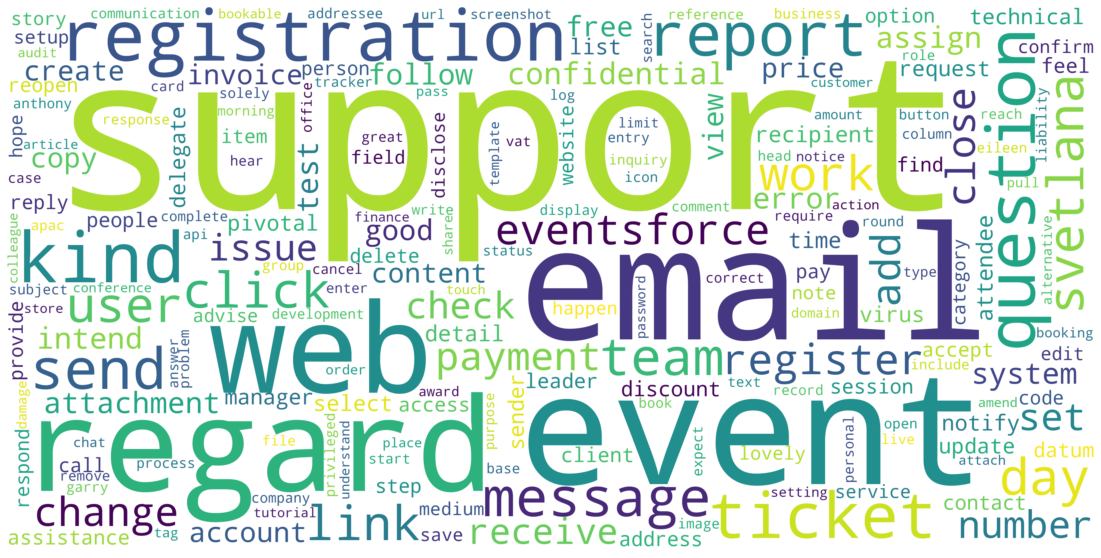

In [8]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=custom_stopwords,
                      background_color="white",
                      width = 4000,
                      height = 2000,
                      max_words=200, 
                      collocations = False,   #remove repetitive words
                      min_word_length = 3
                         ).generate(' '.join(data_lemmatized))
    
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# write to file
wordcloud.to_file("word_cloud_lockdown.png")

# <font color='#31708f'><center>CountVectorizer<a class="anchor" id="fourth-bullet"></a></center></font>

# <font color='#576675'>Create the Document-Word matrix</font>

In [10]:
#Convert a collection of text documents to a matrix of token counts
vectorizer=CountVectorizer(analyzer='word',   
                           token_pattern='[a-zA-Z]{3,}', # only non-digit characters > 3
                           stop_words=custom_stopwords,  # remove stop words
                           lowercase=True,               # convert all words to lowercase
                           # min_df=10,                  # minimum reqd occurences of a word
                           # max_features=50000,         # max number of uniq words
                           
                       )
    
# this step generates word counts for the words in your docs 
data_vectorized=vectorizer.fit_transform(data_lemmatized)

C:\Users\smsta\.conda\envs\testenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\smsta\.conda\envs\testenv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['mon'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


6 rows (6 tickets), 54 columns (unique words)

In [11]:
#check rows(docs) and columns(unique words), minus single character words
#The columns number is raw word frequency
data_vectorized.shape

C:\Users\smsta\.conda\envs\testenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(917, 4880)

In [ ]:
(Optional)

In [ ]:
print(vectorizer.get_feature_names())

In [ ]:
(Optional)

How many times a word has been used in a ticket

In [ ]:
print(data_vectorized.toarray())

# <font color='#576675'>Count</font>

Get top_n_words:

In [12]:
#Count column in Excel spreadsheet
np.asarray(data_vectorized.sum(axis=0))

C:\Users\smsta\.conda\envs\testenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[ 2,  2, 31, ...,  2, 11, 19]], dtype=int64)

In [13]:
sum_words = np.asarray(data_vectorized.sum(axis=0))

C:\Users\smsta\.conda\envs\testenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
sorted_words_freq =sorted(words_freq, 
                          key = lambda x: x[1], 
                          reverse=True)
sorted_words_freq[:10]

C:\Users\smsta\.conda\envs\testenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('support', 8912),
 ('email', 4000),
 ('event', 3906),
 ('regard', 2606),
 ('web', 2379),
 ('registration', 2274),
 ('kind', 2222),
 ('question', 2096),
 ('ticket', 1819),
 ('report', 1681)]

In [15]:
dataframe = pd.DataFrame(sorted_words_freq[:200],
                         columns=['words', 'count'])


dataframe.head(201)

dataframe.style.set_properties(subset=['words', 'count'], **{'width': '200px'})

C:\Users\smsta\.conda\envs\testenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,words,count
0,support,8912
1,email,4000
2,event,3906
3,regard,2606
4,web,2379
5,registration,2274
6,kind,2222
7,question,2096
8,ticket,1819
9,report,1681


In [19]:
# select rows in pandas dataframe
sliced = dataframe.iloc[[1,2,5,7,9,10,16,18,19,20,21,22,24,25,26,31,32,33,34,40,43,44,45,46,48,53,54,57,61,62,64,68,70,71,72,77,85,86,92,102,106,108,109,112,124,126,138,140,141,144,147,149,150,152,154,157,158,163,164,167,168,170,176,196,198], [0,1]]

sliced.style.set_properties(subset=['words', 'count'], **{'width': '200px'})

C:\Users\smsta\.conda\envs\testenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,words,count
1,email,4000
2,event,3906
5,registration,2274
7,question,2096
9,report,1681
10,send,1463
16,user,1163
18,link,1112
19,register,1093
20,eventsforce,1060


C:\Users\smsta\.conda\envs\testenv\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


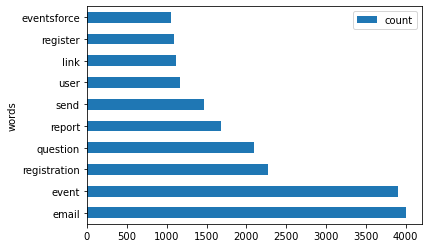

In [23]:
#create horizontal barplot
ax = sliced.head(10).plot.barh(x='words', y='count')